In [6]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, GRU, LSTM, Bidirectional, SpatialDropout1D, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [7]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# nltk.download('stopwords')

# # def remove_english_stopwords(text):
# #    stop_words = set(stopwords.words('english'))
# #    word_tokens = word_tokenize(text)
# #    filtered_text = [word for word in word_tokens if not word in stop_words]
# #    return ' '.join(filtered_text)

# def remove_unnecessary_char(text):
#     text = re.sub('\n',' ',text) # Remove every '\n'
#     text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
#     text = re.sub('  +', ' ', text) # Remove extra spaces
#     return text

# def remove_nonaplhanumeric(text):
#     text = re.sub('[^0-9a-zA-Z]+', ' ', text)
#     return text

In [8]:
# def preprocess(text):
#     text = remove_nonaplhanumeric(text) 
#     text = remove_unnecessary_char(text) 
# #     text = remove_english_stopwords(text) 
#     return text

In [9]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv',index_col='id')
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
# train_data['comment_text'] = train_data['comment_text'].apply(preprocess)
# train_data.head()

In [11]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda row: len(row))
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

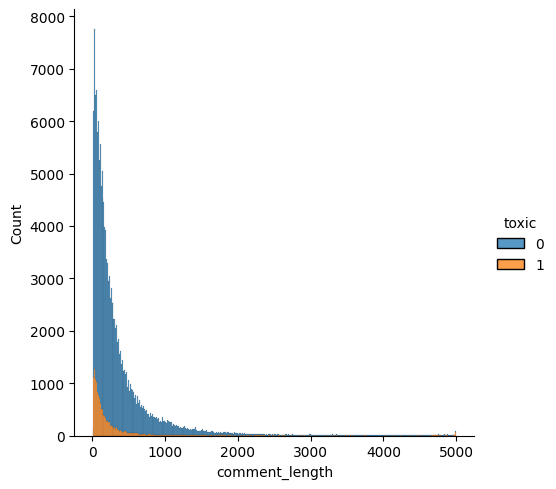

In [12]:
import seaborn as sns
sns.displot(
    data=train_data, 
    x="comment_length", 
    hue='toxic',
    multiple="stack",
)

In [13]:
toxic_data = train_data[train_data['toxic'] == 1]
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,319
0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,57
001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,40


In [14]:
print(
    'max', toxic_data['comment_length'].max(),
    'min', toxic_data['comment_length'].min(),
    'mean', toxic_data['comment_length'].mean(),
    'median', toxic_data['comment_length'].median(),
    '75%', toxic_data['comment_length'].quantile(0.75),
)

max 5000 min 8 mean 295.24604420034 median 123.0 75% 271.0


In [15]:
max_comment_len = 300

In [16]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv',index_col='id')
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [17]:
test_labels_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv',index_col='id')
test_labels_data.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [18]:
test_data = test_data.join(test_labels_data)
test_data = test_data[test_data['toxic'] != -1]
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [19]:
num_words = 10000
encoder = TextVectorization(max_tokens=num_words)
encoder.adapt(train_data['comment_text'].values)

from tensorflow.keras.layers import BatchNormalization

model_gru = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        input_length=max_comment_len,
    ),
    SpatialDropout1D(0.5),
    Bidirectional(GRU(20, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(GRU(20)),
    Dense(6, activation='sigmoid'),
])


In [20]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [21]:
model_gru_save_path = '/kaggle/working/toxic_model_gru'
checkpoint_callback_gru = ModelCheckpoint(
    model_gru_save_path, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_format='tf',
)

In [22]:
!rm -r /kaggle/working/toxic_model_gru

rm: cannot remove '/kaggle/working/toxic_model_gru': No such file or directory


In [23]:
x_train1 = train_data['comment_text'].values
y_train1 = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [24]:
from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,train_size=0.8,shuffle=True,random_state=42)

In [25]:
x_train[:2]

array(['Grandma Terri Should Burn in Trash \nGrandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40',
       ', 9 May 2009 (UTC)\nIt would be easiest if you were to admit to being a member of the involved Portuguese Lodge, and then there would be no requirement to acknowledge whether you had a previous account (Carlos Botelho did not have a good record) or not and I would then remove the sockpuppet template as irrelevant. WP:COI permits people to edit those articles, such as MSJapan does, but just means you have to be more careful in ensuring that references back your edits and that NPOV is upheld.   20:29'],
      dtype=object)

In [26]:
y_train[:2]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [27]:
history_gru = model_gru.fit(
    x_train, 
    y_train, 
    epochs=5, # 15
    batch_size=512,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint_callback_gru],
)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.8973 - auc: 0.8952
Epoch 1: val_accuracy improved from -inf to 0.97866, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 145s 505ms/step - loss: 0.1215 - accuracy: 0.8973 - auc: 0.8952 - val_loss: 0.0854 - val_accuracy: 0.9787 - val_auc: 0.9781
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9894 - auc: 0.9796
Epoch 2: val_accuracy improved from 0.97866 to 0.99405, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 105s 420ms/step - loss: 0.0531 - accuracy: 0.9894 - auc: 0.9796 - val_loss: 0.0520 - val_accuracy: 0.9940 - val_auc: 0.9827
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9932 - auc: 0.9834
Epoch 3: val_accuracy did not improve from 0.99405
250/250 [==============================] - 68s 271ms/step - loss: 0.0470 - accuracy

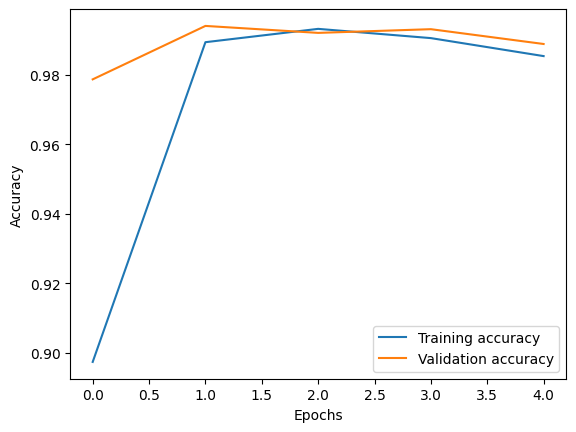

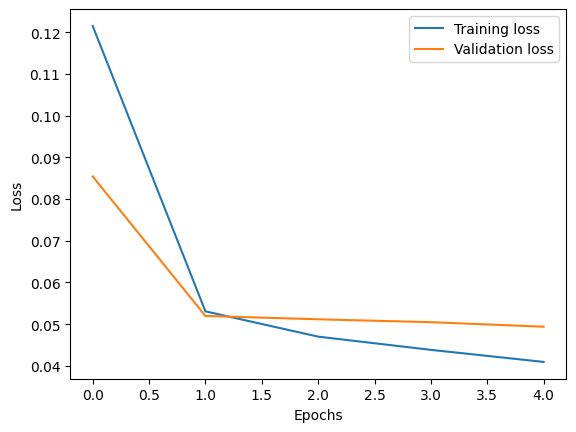

In [28]:
plt.plot(history_gru.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_gru.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_gru.history['loss'], 
         label='Training loss')
plt.plot(history_gru.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
x_test = test_data['comment_text'].values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [30]:
model_gru.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 51s 26ms/step - loss: 0.0835 - accuracy: 0.9886 - auc: 0.9700


[0.08345548063516617, 0.9885585904121399, 0.9700306057929993]

In [31]:
saved_model = load_model(model_gru_save_path)

In [32]:
test_data[test_data['toxic']==1][:5]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",1,0,1,0,1,0


In [33]:
test_data[test_data['toxic']==1][:5]['comment_text'].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.'],
      dtype=object)

In [34]:
test_labels = saved_model.predict(test_data[test_data['toxic']==1][:5]['comment_text'].values)
for labels in test_labels:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 5s 5s/step
[0.26, 0.0, 0.04, 0.0, 0.04, 0.01]
[0.98, 0.13, 0.89, 0.07, 0.71, 0.12]
[0.98, 0.54, 0.98, 0.09, 0.87, 0.23]
[0.19, 0.0, 0.02, 0.0, 0.03, 0.01]
[0.98, 0.09, 0.82, 0.05, 0.71, 0.11]


In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts_val = saved_model.predict(x_val, verbose=1)

for threshold in thresholds:
  y_pred_val = (predicts_val > threshold)
  clr = classification_report(y_val, y_pred_val)
  accuracy = accuracy_score(y_val, y_pred_val)
  f1 = f1_score(y_val, y_pred_val, average='weighted')
  precision = precision_score(y_val, y_pred_val, average='weighted')
  recall = recall_score(y_val, y_pred_val, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")

998/998 [==============================] - 22s 22ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.48      0.94      0.63      3056
           1       0.28      0.85      0.42       321
           2       0.59      0.93      0.72      1715
           3       0.04      0.14      0.06        74
           4       0.51      0.90      0.65      1614
           5       0.15      0.50      0.23       294

   micro avg       0.46      0.90      0.61      7074
   macro avg       0.34      0.71      0.45      7074
weighted avg       0.48      0.90      0.63      7074
 samples avg       0.06      0.09      0.07      7074

F1 Score: 0.6259464452563138
Precision: 0.48446036797086367
Recall: 0.8977947413061916

Accuracy: 0.8268525771580761

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.61      0.89      0.73      3056
           1       0.37      0.65      0.47       321


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3056
           1       0.52      0.41      0.46       321
           2       0.79      0.79      0.79      1715
           3       0.00      0.00      0.00        74
           4       0.69      0.72      0.71      1614
           5       0.00      0.00      0.00       294

   micro avg       0.74      0.73      0.74      7074
   macro avg       0.46      0.46      0.46      7074
weighted avg       0.70      0.73      0.71      7074
 samples avg       0.07      0.07      0.07      7074

F1 Score: 0.7137505378774841
Precision: 0.6985525488939593
Recall: 0.7309867119027424

Accuracy: 0.9107942973523422

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      3056
           1       0.55      0.26      0.35       321
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      3056
           1       1.00      0.01      0.01       321
           2       0.91      0.65      0.76      1715
           3       0.00      0.00      0.00        74
           4       0.84      0.43      0.57      1614
           5       0.00      0.00      0.00       294

   micro avg       0.89      0.56      0.68      7074
   macro avg       0.61      0.30      0.35      7074
weighted avg       0.84      0.56      0.65      7074
 samples avg       0.06      0.05      0.05      7074

F1 Score: 0.6511039118369494
Precision: 0.8409020388244529
Recall: 0.5561210065026859

Accuracy: 0.9180009399968667

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      3056
           1       0.00      0.00      0.00       321
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts = saved_model.predict(x_test, verbose=1)

for threshold in thresholds:
  y_pred = (predicts > threshold)
  f1 = f1_score(y_test, y_pred, average='weighted')
  accuracy = accuracy_score(y_test, y_pred)
  clr = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")

2000/2000 [==============================] - 49s 24ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.32      0.96      0.49      6090
           1       0.13      0.85      0.23       367
           2       0.36      0.93      0.51      3691
           3       0.07      0.18      0.11       211
           4       0.31      0.92      0.46      3427
           5       0.16      0.52      0.25       712

   micro avg       0.31      0.91      0.46     14498
   macro avg       0.23      0.73      0.34     14498
weighted avg       0.31      0.91      0.46     14498
 samples avg       0.06      0.09      0.07     14498

F1 Score: 0.46364840459926676
Precision: 0.3122292819784252
Recall: 0.908539108842599

Accuracy: 0.731782800337616

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.38      0.94      0.54      6090
           1       0.20      0.70      0.32       367
  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.3
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.42      0.91      0.58      6090
           1       0.25      0.56      0.35       367
           2       0.52      0.84      0.64      3691
           3       0.00      0.00      0.00       211
           4       0.45      0.80      0.58      3427
           5       0.15      0.02      0.03       712

   micro avg       0.45      0.80      0.57     14498
   macro avg       0.30      0.52      0.36     14498
weighted avg       0.43      0.80      0.55     14498
 samples avg       0.07      0.08      0.07     14498

F1 Score: 0.5538929763807384
Precision: 0.4320197308781696
Recall: 0.7996275348323907

Accuracy: 0.8202976023007909

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.46      0.89      0.61      6090
           1       0.27      0.40      0.32       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.50      0.86      0.63      6090
           1       0.31      0.27      0.29       367
           2       0.66      0.75      0.70      3691
           3       0.00      0.00      0.00       211
           4       0.60      0.65      0.63      3427
           5       0.00      0.00      0.00       712

   micro avg       0.55      0.71      0.62     14498
   macro avg       0.35      0.42      0.37     14498
weighted avg       0.53      0.71      0.60     14498
 samples avg       0.07      0.07      0.07     14498

F1 Score: 0.5996018445800549
Precision: 0.5285407920778191
Recall: 0.7123051455373155

Accuracy: 0.8568101534902622

Threshold: 0.6
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.54      0.82      0.65      6090
           1       0.45      0.13      0.20       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.58      0.77      0.66      6090
           1       0.42      0.03      0.05       367
           2       0.78      0.63      0.69      3691
           3       0.00      0.00      0.00       211
           4       0.77      0.41      0.53      3427
           5       0.00      0.00      0.00       712

   micro avg       0.65      0.58      0.61     14498
   macro avg       0.42      0.31      0.32     14498
weighted avg       0.63      0.58      0.58     14498
 samples avg       0.07      0.06      0.06     14498

F1 Score: 0.582778130401249
Precision: 0.6341406448178757
Recall: 0.5818733618430129

Accuracy: 0.8800056269342587

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      6090
           1       1.00      0.00      0.01       367
  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [37]:
!zip -r /kaggle/working/toxic_model_bidir_gru.zip /kaggle/working/toxic_model_gru

  adding: kaggle/working/toxic_model_gru/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/assets/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/variables/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/variables/variables.index (deflated 66%)
  adding: kaggle/working/toxic_model_gru/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/toxic_model_gru/keras_metadata.pb (deflated 91%)
  adding: kaggle/working/toxic_model_gru/saved_model.pb (deflated 89%)
  adding: kaggle/working/toxic_model_gru/fingerprint.pb (stored 0%)
